##### XGB-Stepregression   
##20220409sym编写 
### 简介：  
使用逐步回归的方法提取最重要的特征相互作用
### 更新记录：  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
c_time = time.strftime("%Y%m%d_%H%M%S", time.localtime())
c_time_m = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

In [2]:
# 参数
# ======== System Setup ========
Version = 'V1.0cyt'
EPOCH = 80
CORE_NUM = 10
TRAIN_TEST_SPLIT = 0.85
# ======== Fit Data Input ========
S_N = 417  # 样本数
F_N = 238  # 特征数
NUM_FEATURE_SELECTED = 40
INPUT_X = 'Features_'+str(S_N)+'_'+str(F_N)+'.csv'
INPUT_Y = 'Values_ActTotal_'+str(S_N)+'.csv'
INPUT_TITLE = 'Title_'+str(F_N)+'.csv'
# AMI_TITLE = 'Title_566.csv'
RECORD_NAME = 'Record_AFS_'+Version+'_'+c_time+'.txt'

In [3]:
import shap
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import model_selection
import joblib
from multiprocessing import Pool

In [4]:
import os
from pathlib import Path
DIR = 'SHAP-GBRT_'+Version+'_'+c_time
os.mkdir(DIR)
X = np.loadtxt(INPUT_X, delimiter=',')
y = np.loadtxt(INPUT_Y)
# factor_mean = np.mean(y)
# factor_std = np.std(y)
# y = (y-factor_mean)/factor_std
title = np.loadtxt(INPUT_TITLE, dtype=str, delimiter=',', comments='!')
# ami_title = np.loadtxt(AMI_TITLE, dtype=str, delimiter=',', comments='!')

# 打乱和切分数据集
np.random.seed(2023)
TRAIN_TEST_SPLIT = 0.8
VALIDATION_SPLIT = 0.2
point1 = round(X.shape[0]*VALIDATION_SPLIT)
point2 = round((X.shape[0] - point1) * TRAIN_TEST_SPLIT)
permutation = np.random.permutation(y.shape[0])
valid_idx = permutation[:point1]
train_idx = permutation[point1:point1+point2]
test_idx = permutation[point1+point2:]
X_valid = X[valid_idx, :]
y_valid = y[valid_idx]
X_train = X[train_idx, :]
y_train = y[train_idx]
X_test = X[test_idx, :]
y_test = y[test_idx]
train_test_idx = np.concatenate((train_idx, test_idx)).reshape(-1)
X = X[train_test_idx, :]
y = y[train_test_idx]

val_i = 'Valid_index.csv'
val_i = Path('.', DIR, val_i)
train_i = 'Train_index.csv'
train_i = Path('.', DIR, train_i)
test_i = 'Test_index.csv'
test_i = Path('.', DIR, test_i)
np.savetxt(val_i, valid_idx, fmt='%s', delimiter=',')
np.savetxt(train_i, train_idx, fmt='%s', delimiter=',')
np.savetxt(test_i, test_idx, fmt='%s', delimiter=',')

RECORD_NAME = Path('.', DIR, RECORD_NAME)
with open(RECORD_NAME, 'w') as f1:
    f1.write('Record of GBRT-Stepregression '+Version+'\n\n')
    f1.write('Generation time: '+time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())+'\n\n\n')
    f1.write('Inputfiles are: '+INPUT_X+'+'+INPUT_Y+'+'+INPUT_TITLE+'\n\n\n')
    f1.write('EPOCH='+str(EPOCH)+' CORENUM='+str(CORE_NUM)+' splitratio='+str(round(TRAIN_TEST_SPLIT,3))+'\n\n\n')

In [5]:
clf = GradientBoostingRegressor(n_estimators=200, verbose=0, loss='squared_error', validation_fraction=0.15, n_iter_no_change=50, 
                                tol=0.00025, subsample=0.7538928719433944, warm_start=False, learning_rate=10**(-1.3445093241536106), min_impurity_decrease=0.002804794644669451, 
                                max_depth=10, max_features=0.35801348562560875, max_leaf_nodes=14)    
paras = clf.get_params()
mse_list = []
mae_list = []
r2_list = []

In [6]:
def GBRT_Fit(X, y, X_train, y_train, X_test, y_test, paras):
    clf_new = GradientBoostingRegressor()
    for k, v in paras.items():
        clf_new.set_params(**{k: v})
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    # 拟合模型
    clf_new.fit(X_train, y_train)
    # 计算损失
    y_pred = clf_new.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    shap_values = shap.TreeExplainer(clf_new).shap_values(X)
#     s = np.mean(clf_new.predict(X))-np.mean(y_train)
#     s2 = np.mean(clf_new.predict(X))-np.mean(y)
#     print(np.sum(shap_values), s, s2)
#     # f_i = clf_new.feature_importances_
#      temp = [mse, mae, r2, shap_values, s, s2]
    temp = [mse, mae, r2, shap_values]
#     print('   MSE: %.5f' % mse, '  MAE: %.5f' % mae, '  R^2: %.5f' % r2)
    del y_pred
    return (temp, 'None')
def flatten(li):
    return sum(([x] if not isinstance(x, list) else flatten(x) for x in li), [])

In [7]:
def poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,X, y, paras):
    r_l = []
    point = round(X.shape[0]*TRAIN_TEST_SPLIT)
    for _ in range(int(EPOCH/CORE_NUM)):
#         print('Round', CORE_NUM*(_)+1, 'Begin:')
        pool = Pool(CORE_NUM)
        for __ in range(CORE_NUM):
            permutation = np.random.permutation(y.shape[0])
            train_idx = permutation[:point]
            test_idx = permutation[point:]
            X_train = X[train_idx, :]
            y_train = y[train_idx]
            X_test = X[test_idx, :]
            y_test = y[test_idx]
            r = pool.apply_async(GBRT_Fit, args=(X, y, X_train, y_train, X_test, y_test, paras,))
            r_l.append(r)
        pool.close()
        pool.join()
    mse_list=[]
    mae_list=[]
    r2_list=[]
#     shap_m = np.zeros((S_N, F_Ntemp))
    for i in range(len(r_l)):
        r = r_l[i]
        results = r.get()
        temp = results[0]
        mse = temp[0]
        mae = temp[1]
        r2 = temp[2]
        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)

    mse1=np.mean(mse_list)
    mae1=np.mean(mae_list)
    r21=np.mean(r2_list)
    temp = [mse1, mae1, r21]
    return temp

In [8]:
def select_feature(X, y, number, one_by_one=True):
    if one_by_one:
        global feature_selected, feature_unselected
        mse_list = []
        mae_list = []
        r2_list = []
        print('Feature {} selecting...'.format(number + 1))
        for i in feature_unselected:
            f_index_temp = f_index.copy()
            f_index_temp.append(np.where(title==i)[0][0])
            X_temp = X[:, f_index_temp].reshape((len(train_test_idx), -1))
            temp = poolfit(TRAIN_TEST_SPLIT, EPOCH, CORE_NUM, X_temp, y, paras)
            mse = temp[0]
            mae = temp[1]
            r2 = temp[2]
            mse_list.append(mse)
            mae_list.append(mae)
            r2_list.append(r2)
        best_f_index = np.where(r2_list==np.max(r2_list))[0][0]
        best_f = feature_unselected[best_f_index]
        best_mse_list.append(mse_list[best_f_index])
        best_mae_list.append(mae_list[best_f_index])
        best_r2_list.append(r2_list[best_f_index])
        feature_selected.append(best_f)
        feature_unselected = np.delete(feature_unselected, np.where(feature_unselected==best_f)[0][0])
        f_index.append(np.where(title==best_f)[0][0])
        print('Finished!')
        print('Feature {} is '.format(number + 1) + best_f)
        print('Feature list is ', feature_selected)
        print('   MSE: %.5f' % best_mse_list[-1], '  MAE: %.5f' % best_mae_list[-1], '  R^2: %.5f' % best_r2_list[-1])
        print('\n')
        with open(RECORD_NAME, 'a') as f1:
            f1.write('Feature {} is '.format(number + 1) + best_f)
            f1.write('\n')
            f1.write('Feature list is ')
            print(feature_selected, file=f1)
            f1.write('   MSE: %.5f' % best_mse_list[-1] + '  MAE: %.5f' % best_mae_list[-1] + '  R^2: %.5f' % best_r2_list[-1])
            f1.write('\n')
    else:
        feature_unselected = np.hstack((title[:429], ami_title))
        mse_list = []
        mae_list = []
        r2_list = []
        print('Feature {} selecting...'.format(number + 1))
        for i in feature_unselected:
            last_index = 429
            f_index_temp = f_index.copy()
            if np.where(title==i)[0][0] <= 429:
                f_index_temp.append(np.where(title==i)[0][0])
                X_temp = X[:, f_index_temp].reshape((len(train_test_idx), -1))
            else:
                for k in range(7):
                    f_index_temp.append((np.where(title==i)[0][0]-last_index)*7 + last_index + k)
                last_index = np.where(title==i)[0][0]
                X_temp = X[:, f_index_temp].reshape((len(train_test_idx), -1))
            temp = poolfit(TRAIN_TEST_SPLIT, EPOCH, CORE_NUM, X_temp, y, paras)
            mse = temp[0]
            mae = temp[1]
            r2 = temp[2]
            mse_list.append(mse)
            mae_list.append(mae)
            r2_list.append(r2)
        best_f_index = np.where(r2_list==np.max(r2_list))[0][0]
        best_f = feature_unselected[best_f_index]
        best_mse_list.append(mse_list[best_f_index])
        best_mae_list.append(mae_list[best_f_index])
        best_r2_list.append(r2_list[best_f_index])
        feature_selected.append(best_f)
        feature_unselected = np.delete(feature_unselected, np.where(feature_unselected==best_f)[0][0])
        f_index.append(np.where(title==best_f)[0][0])
        print('Finished!')
        print('Feature {} is '.format(number + 1) + best_f)
        print('Feature list is ', feature_selected)
        print('   MSE: %.5f' % best_mse_list[-1], '  MAE: %.5f' % best_mae_list[-1], '  R^2: %.5f' % best_r2_list[-1])
        print('\n')
        with open(RECORD_NAME, 'a') as f1:
            f1.write('Feature {} is '.format(number + 1) + best_f)
            f1.write('\n')
            f1.write('Feature list is ')
            print(feature_selected, file=f1)
            f1.write('   MSE: %.5f' % best_mse_list[-1] + '  MAE: %.5f' % best_mae_list[-1] + '  R^2: %.5f' % best_r2_list[-1])
            f1.write('\n')

In [9]:
# X = np.loadtxt(INPUT_X, delimiter=',')
# y = np.loadtxt(INPUT_Y)
title = np.loadtxt(INPUT_TITLE, dtype=str, delimiter=',', comments='!')
f_index = []
feature_selected = []
feature_unselected = title
best_mse_list = []
best_mae_list = []
best_r2_list = []
for j in range(NUM_FEATURE_SELECTED):     
    select_feature(X, y, j)

Feature 1 selecting...
Finished!
Feature 1 is SMR_VSA5
Feature list is  ['SMR_VSA5']
   MSE: 0.19932   MAE: 0.35523   R^2: 0.13401


Feature 2 selecting...
Finished!
Feature 2 is PEOE_VSA4
Feature list is  ['SMR_VSA5', 'PEOE_VSA4']
   MSE: 0.18285   MAE: 0.34042   R^2: 0.22550


Feature 3 selecting...
Finished!
Feature 3 is EState_VSA10
Feature list is  ['SMR_VSA5', 'PEOE_VSA4', 'EState_VSA10']
   MSE: 0.16251   MAE: 0.31787   R^2: 0.29047


Feature 4 selecting...
Finished!
Feature 4 is A2_A
Feature list is  ['SMR_VSA5', 'PEOE_VSA4', 'EState_VSA10', 'A2_A']
   MSE: 0.15551   MAE: 0.31049   R^2: 0.33247


Feature 5 selecting...
Finished!
Feature 5 is NOCount
Feature list is  ['SMR_VSA5', 'PEOE_VSA4', 'EState_VSA10', 'A2_A', 'NOCount']
   MSE: 0.14882   MAE: 0.30320   R^2: 0.36756


Feature 6 selecting...
Finished!
Feature 6 is A1_A
Feature list is  ['SMR_VSA5', 'PEOE_VSA4', 'EState_VSA10', 'A2_A', 'NOCount', 'A1_A']
   MSE: 0.14656   MAE: 0.29750   R^2: 0.36662


Feature 7 selecting...


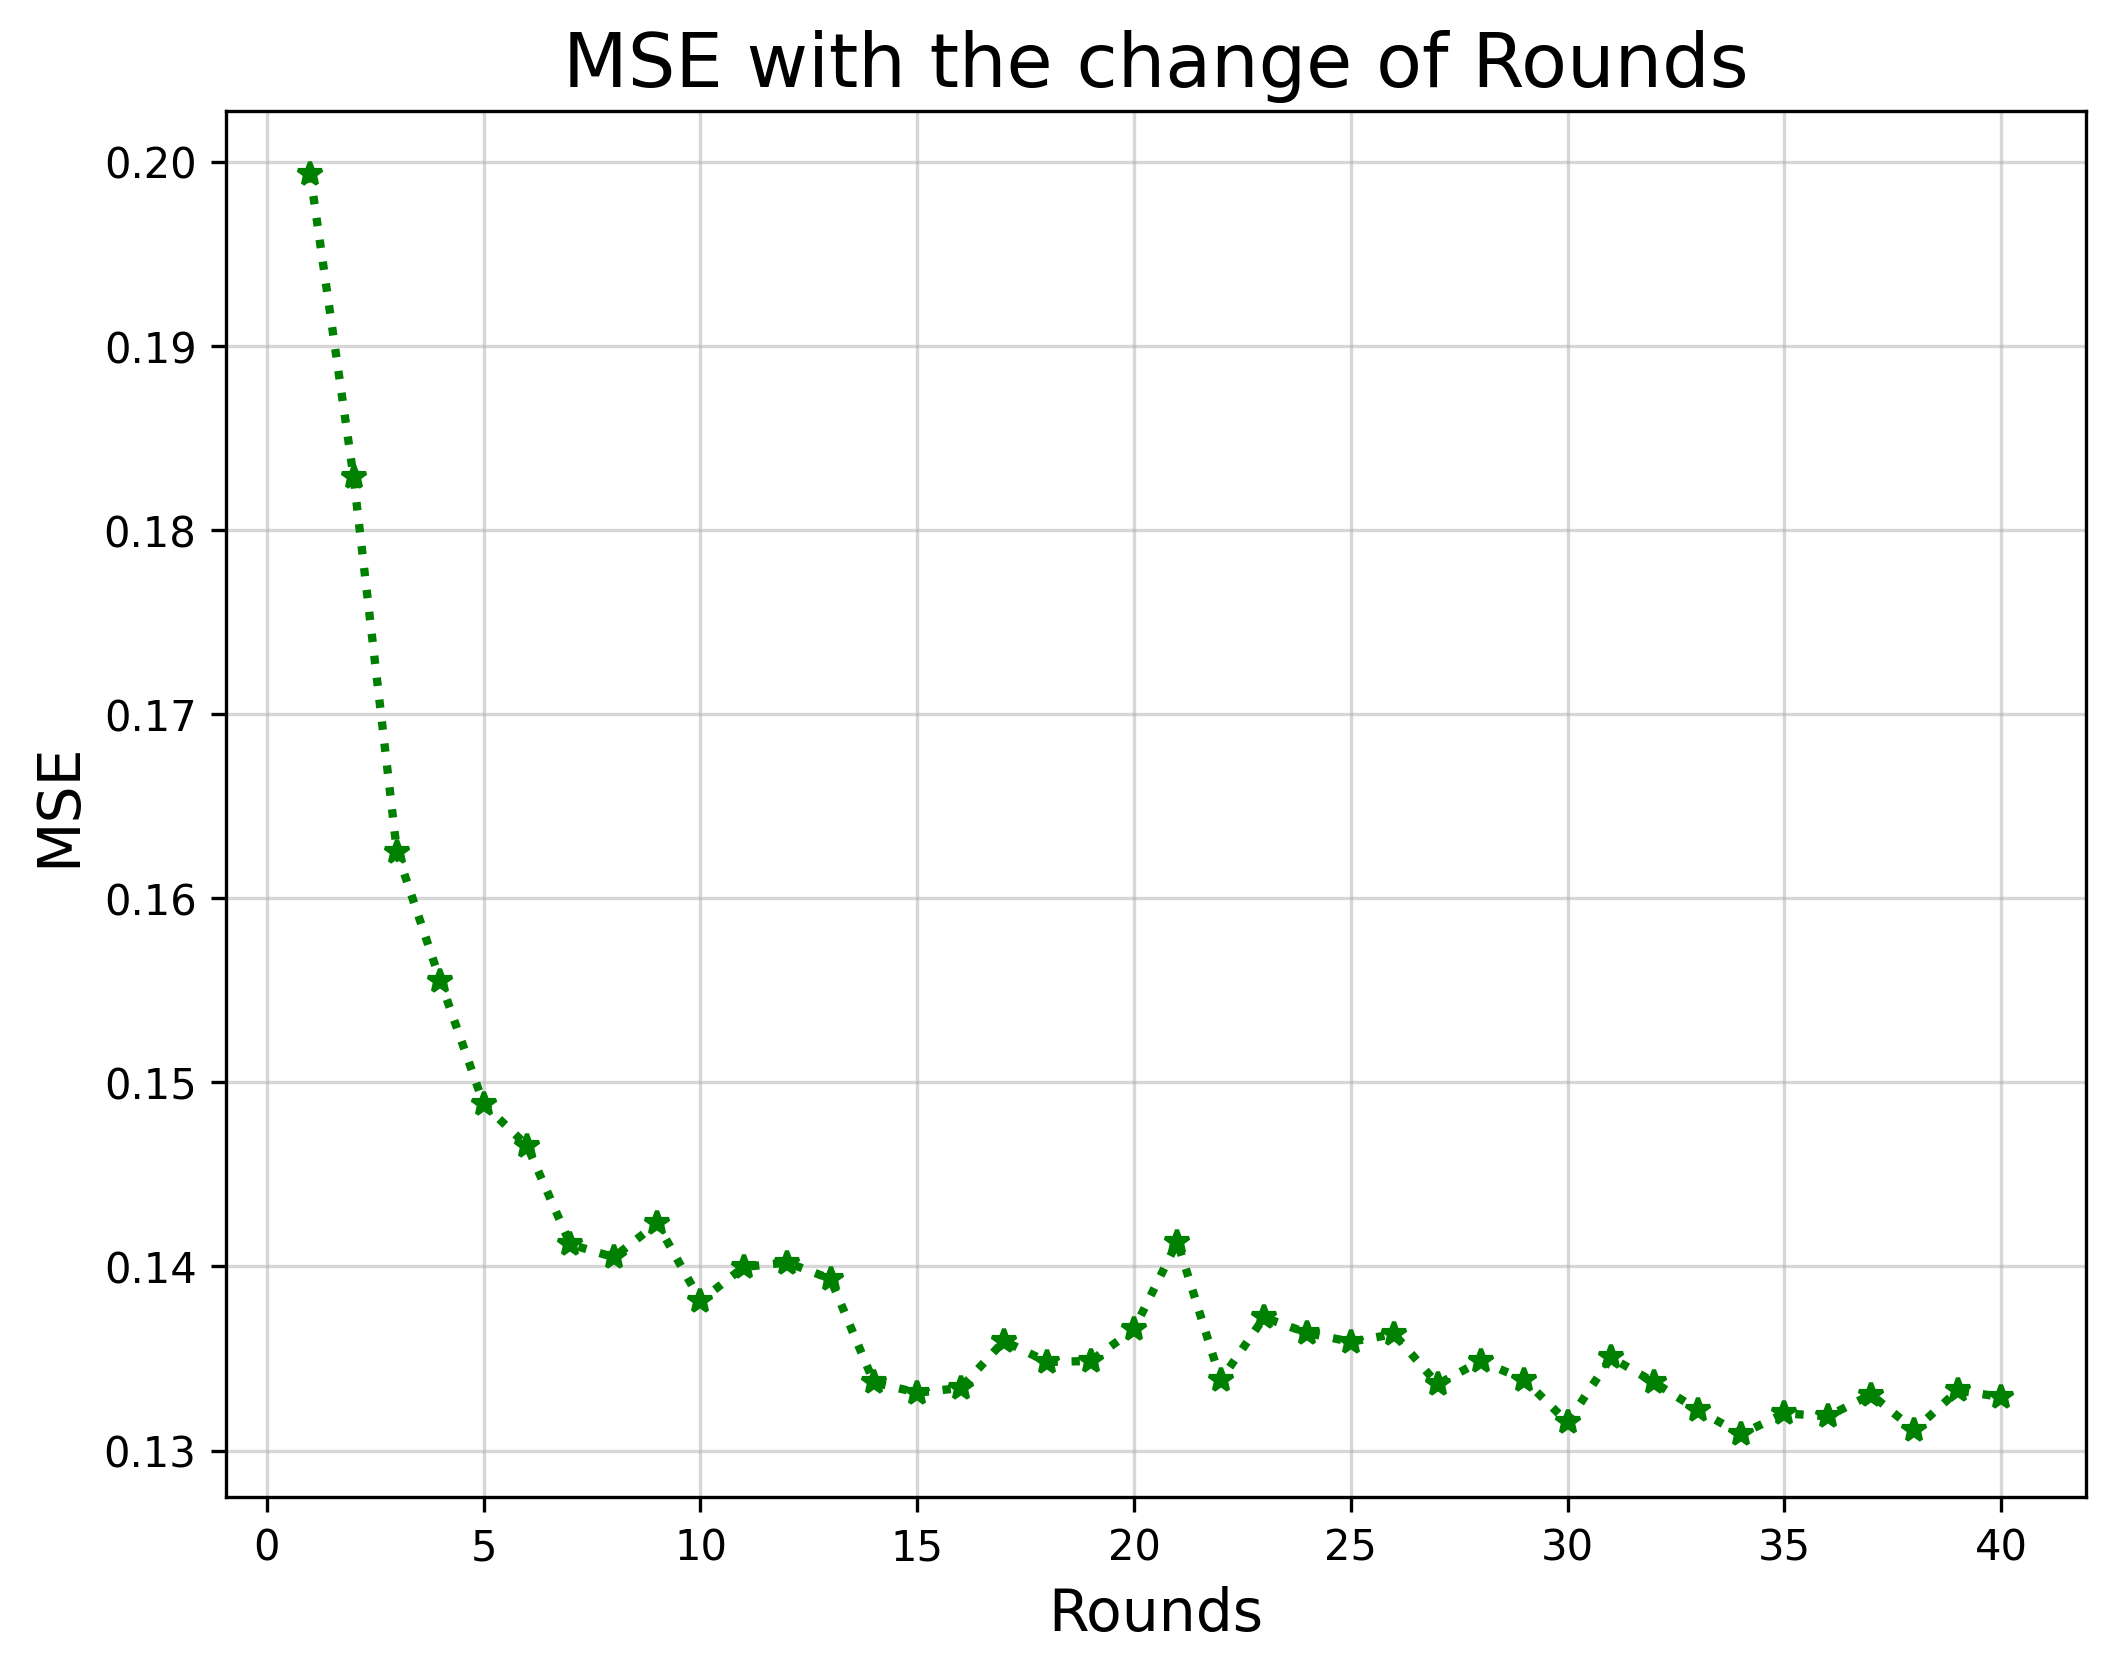

In [16]:
import matplotlib.pyplot as plt
import numpy as np
# F_N=20
# make data
x = np.linspace(1, len(feature_selected), len(feature_selected))
y = best_mse_list
# plot
plt.figure(figsize=(8, 6), dpi=300)
plt.title('MSE with the change of Rounds', fontsize=18)
plt.plot(x, y, linewidth=2.0, color='g', linestyle=':', marker='*')
plt.xlabel('Rounds', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.grid(alpha=0.5)
plt.show()
mae_change = 'mse_change.png'
mae_change = Path('.', DIR, mae_change)
plt.savefig(mae_change)

<Figure size 640x480 with 0 Axes>

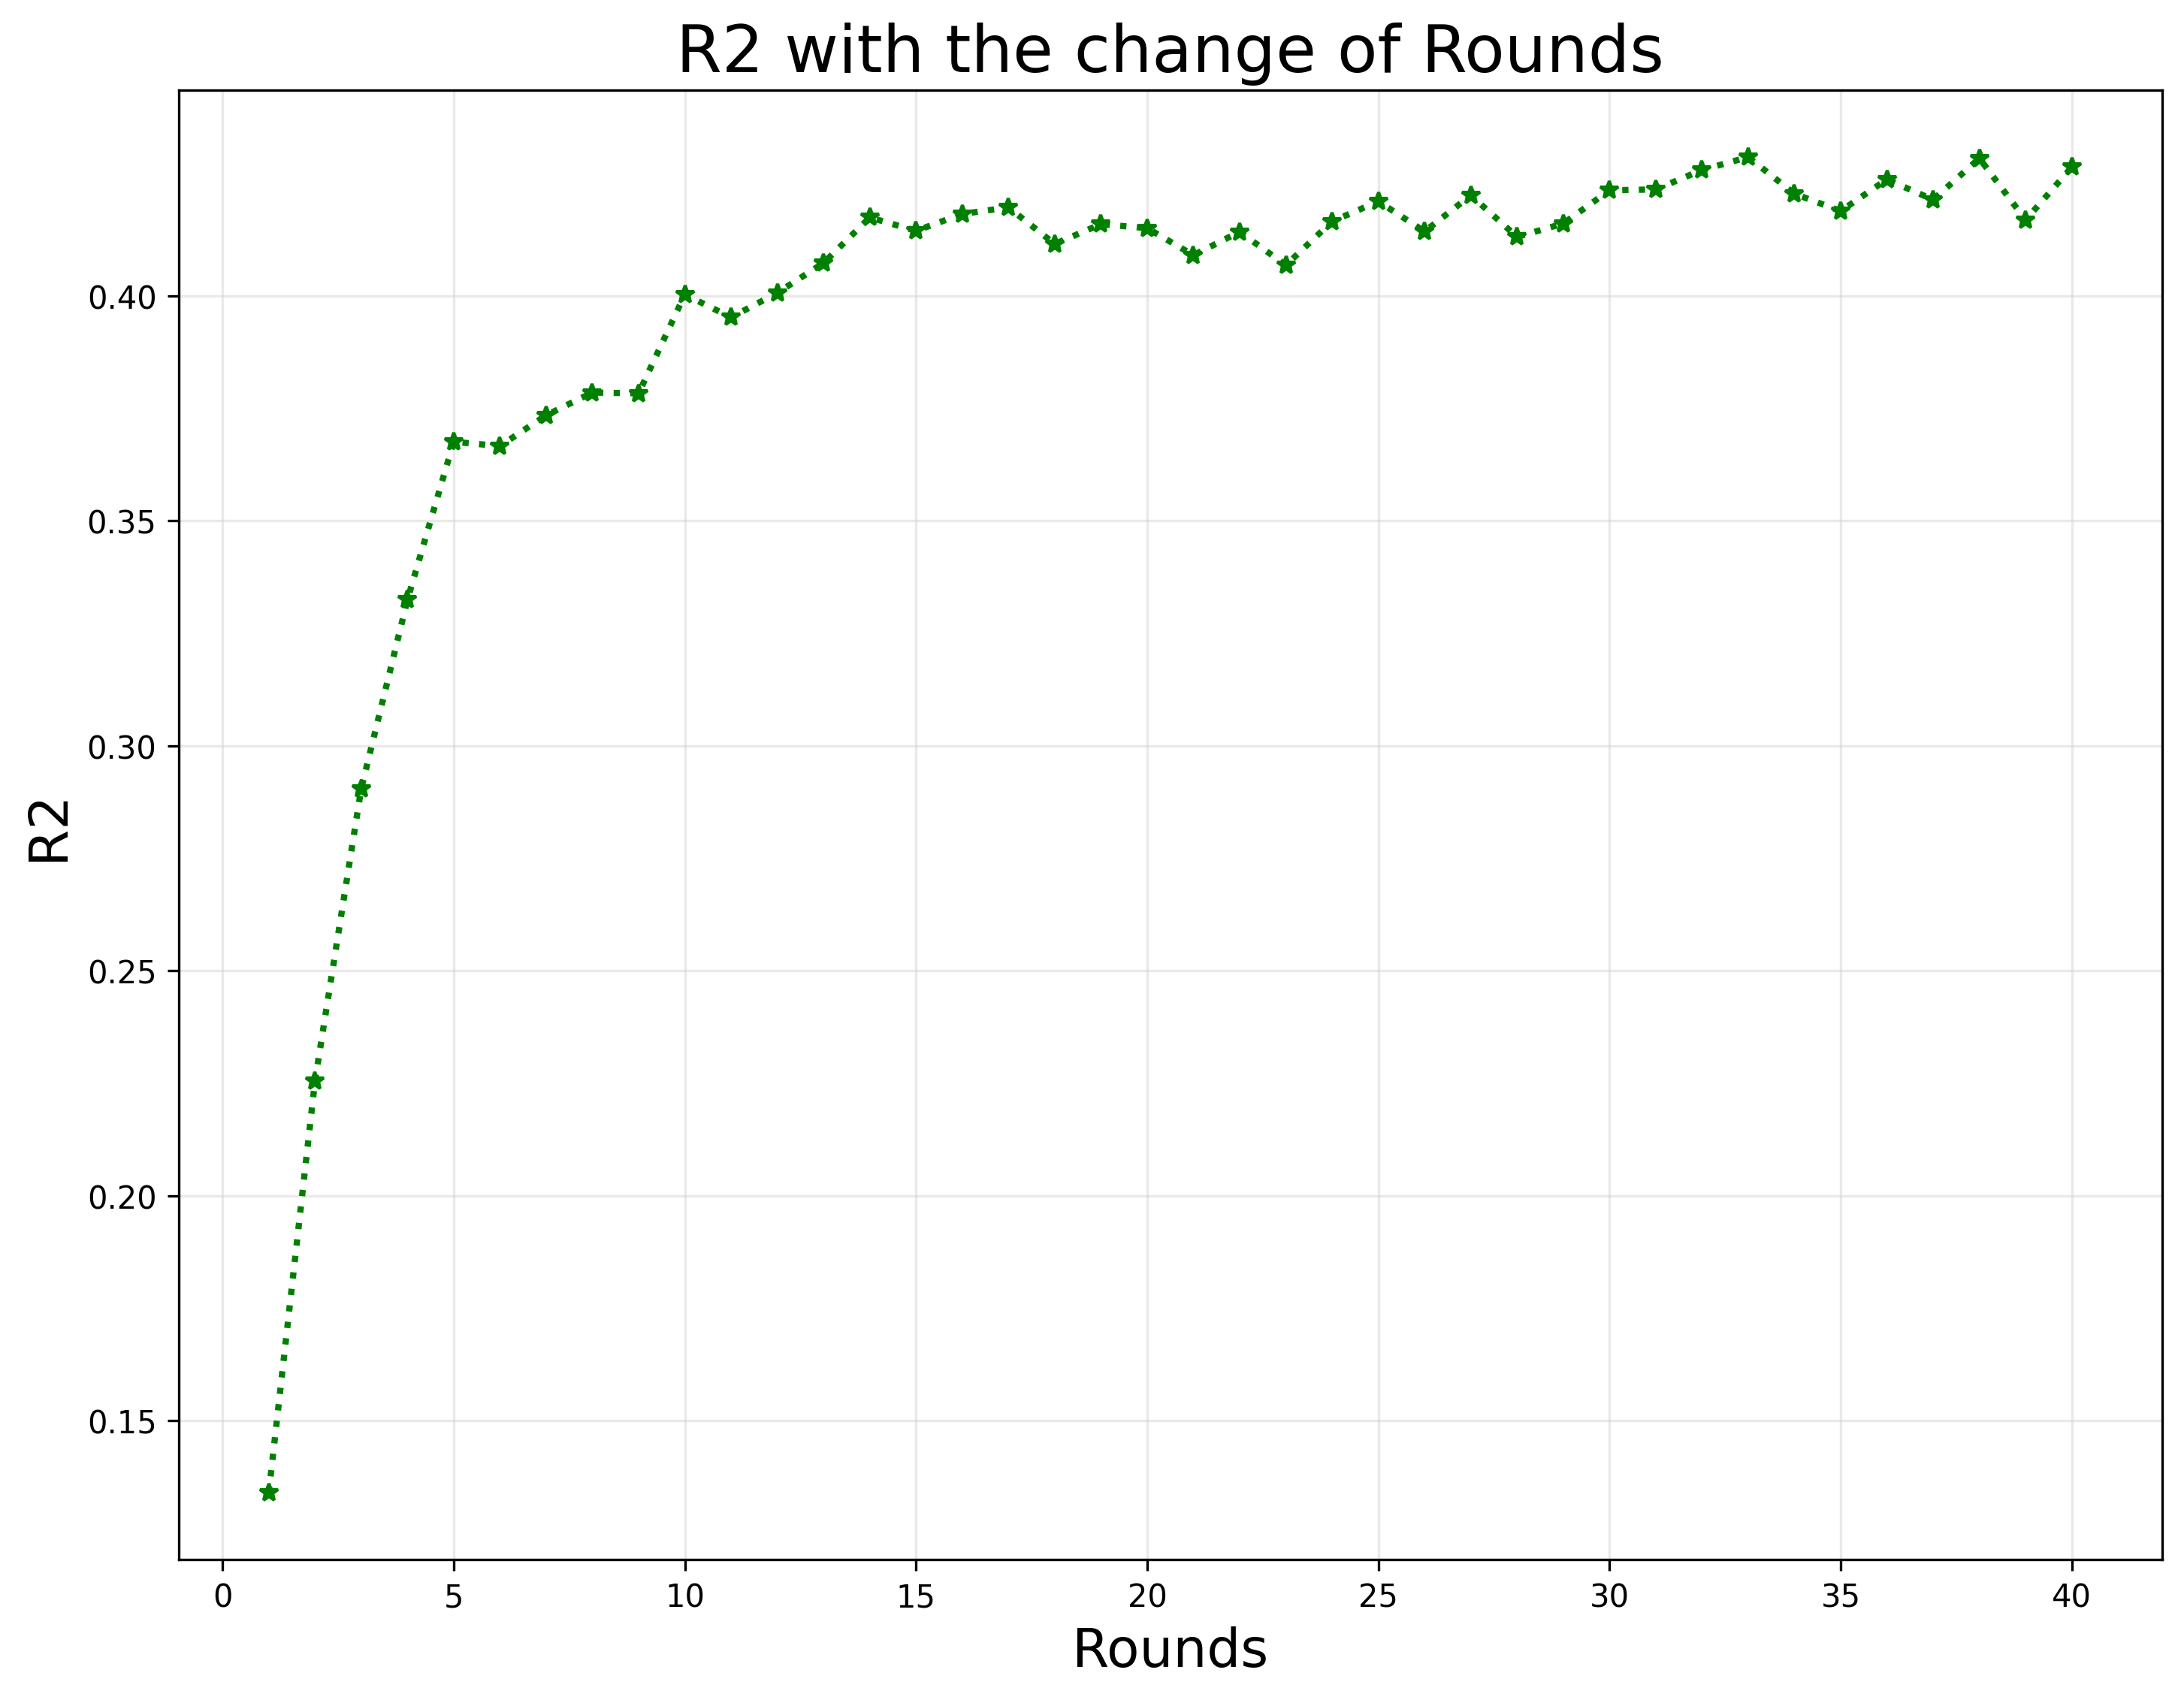

In [17]:
x = np.linspace(1, len(feature_selected), len(feature_selected))
y = best_r2_list
# plot
fig = plt.figure(figsize=(10, 8), dpi=300)
ax = fig.add_axes([0.11, 0.08, 0.88, 0.815])
plt.title('R2 with the change of Rounds', fontsize=21)
ax.plot(x, y, linewidth=2.0, color='g', linestyle=':', marker='*')
ax.set_xlabel('Rounds', fontsize=17)
ax.set_ylabel('R2', fontsize=17)
plt.grid(which='major', color='#D5D5D5', alpha=0.5)
r2_change = 'r2_change.png'
r2_change = Path('.', DIR, r2_change)
plt.savefig(r2_change)
plt.show()

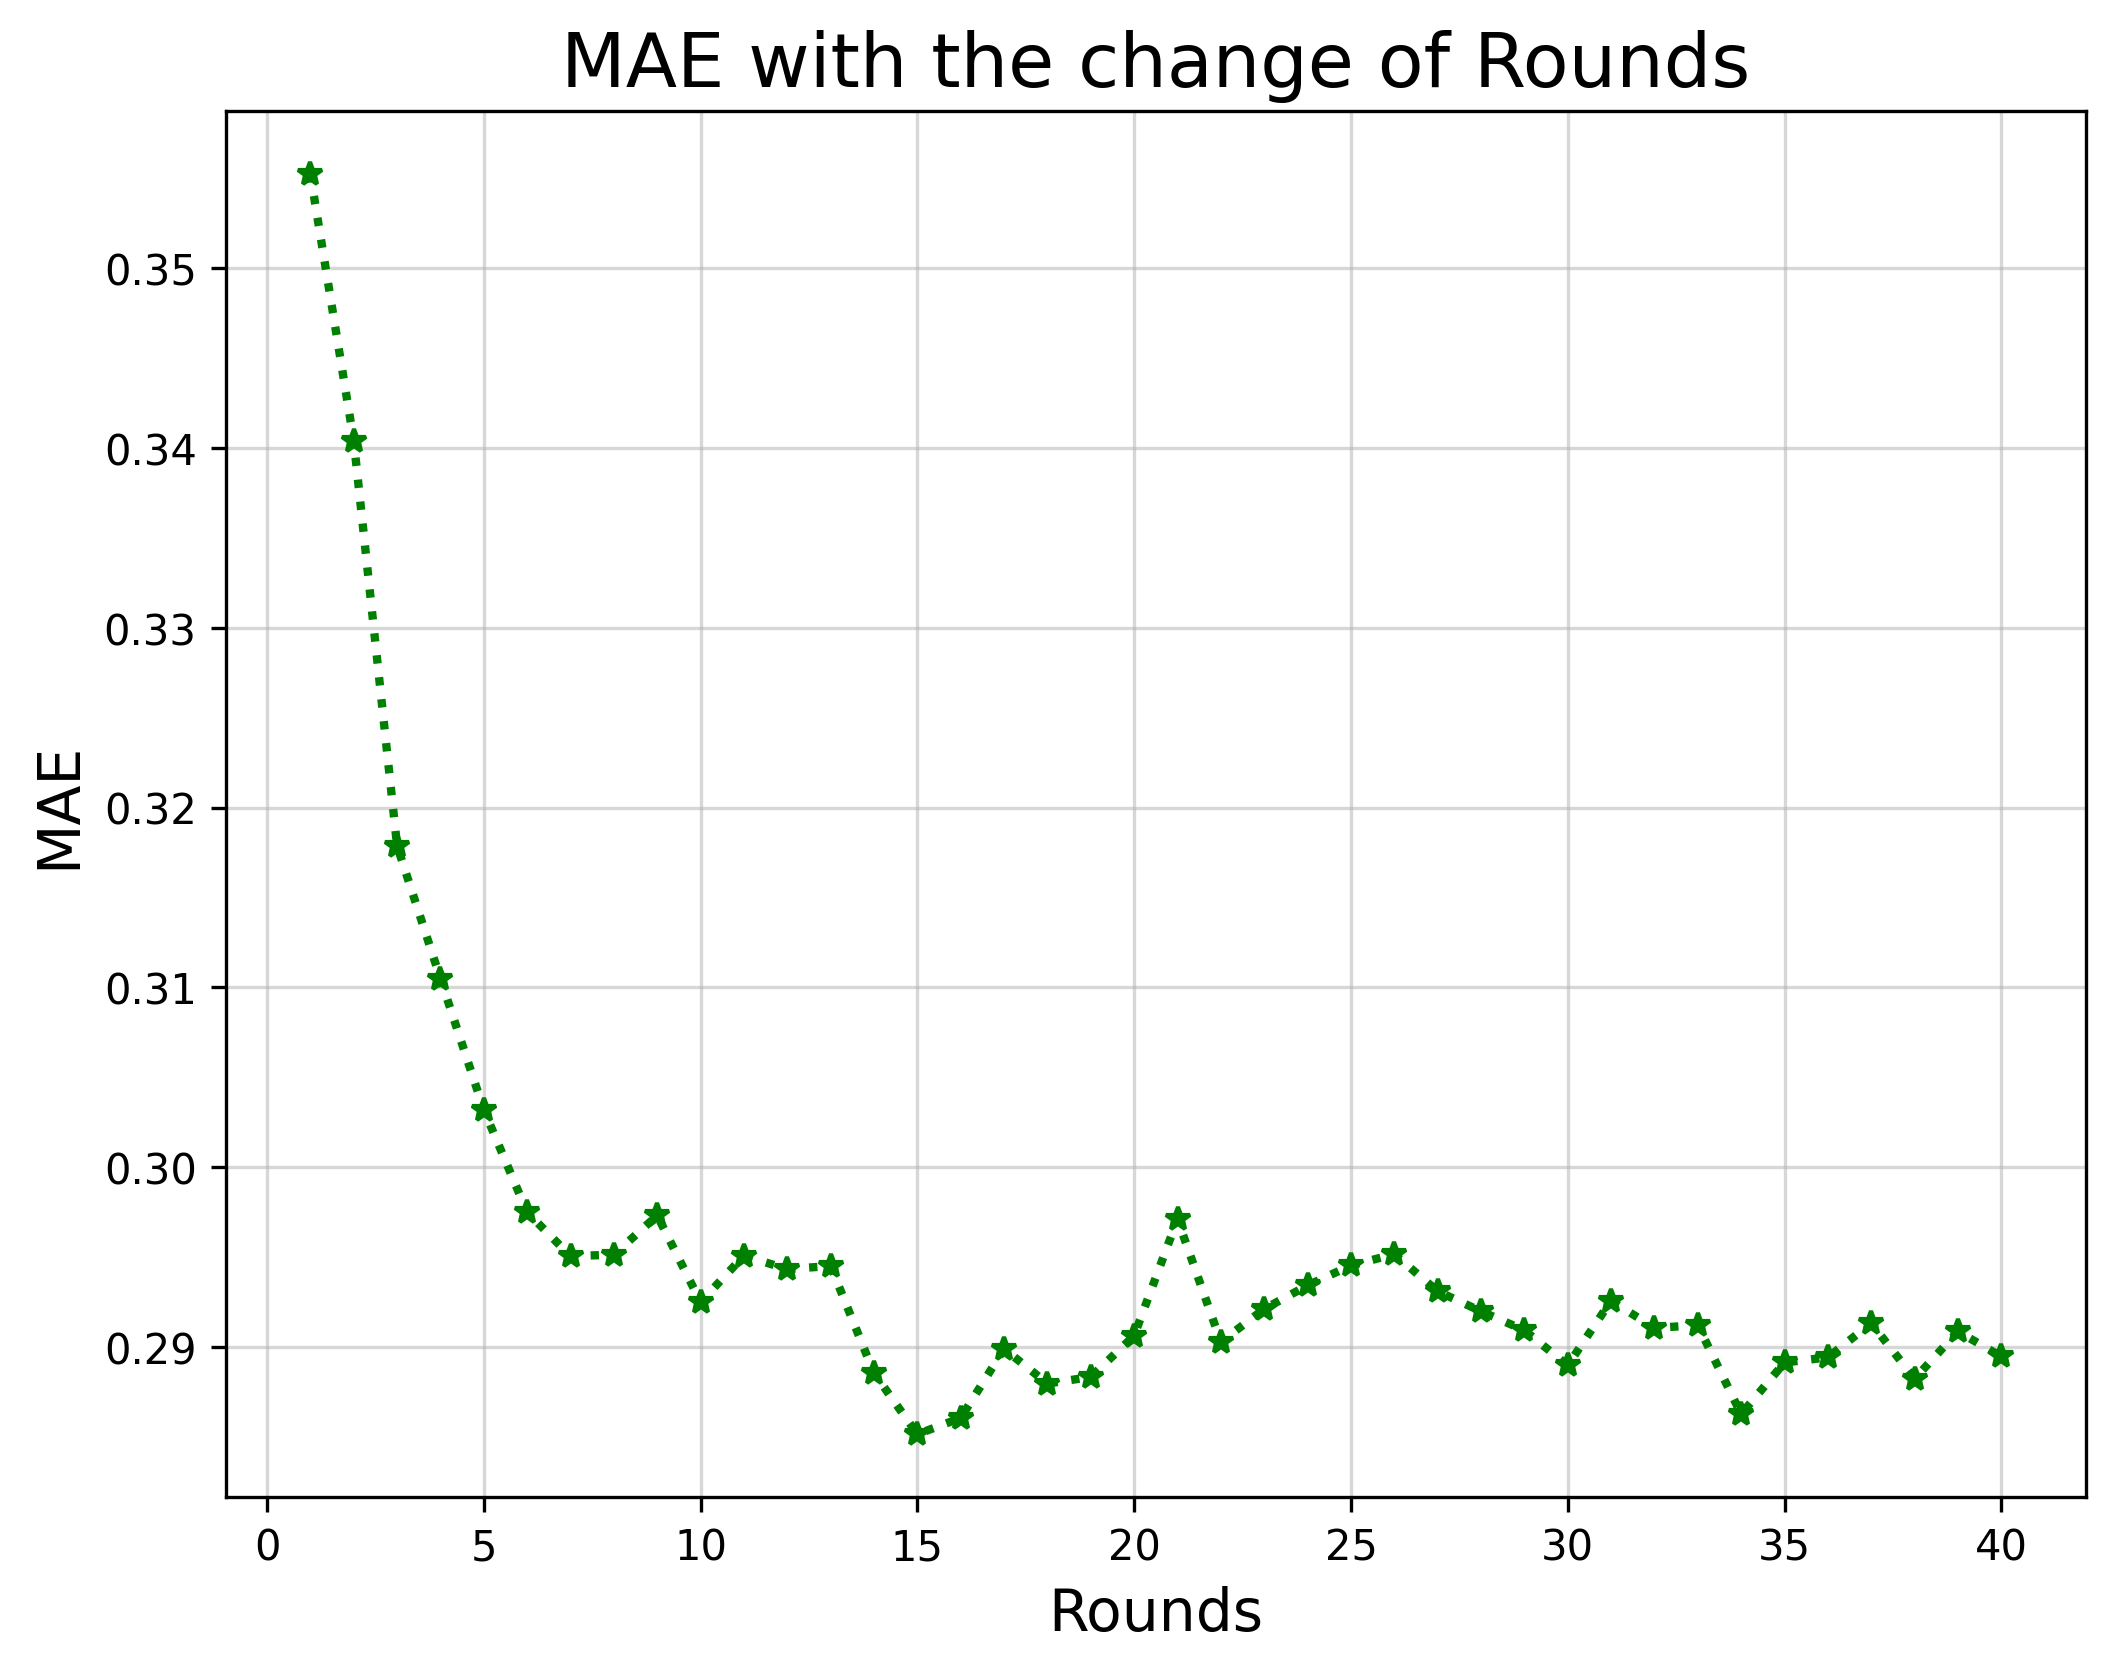

In [18]:
x = np.linspace(1, len(feature_selected), len(feature_selected))
y = best_mae_list
# plot
plt.figure(figsize=(8, 6), dpi=300)
plt.title('MAE with the change of Rounds', fontsize=18)
plt.plot(x, y, linewidth=2.0, color='g', linestyle=':', marker='*')
plt.xlabel('Rounds', fontsize=14)
plt.ylabel('MAE', fontsize=14)
# plt.xticks(np.arange(1, 20, 2))
plt.grid(alpha=0.5)
mae_change = 'mae_change.png'
mae_change = Path('.', DIR, mae_change)
plt.savefig(mae_change)
plt.show()

In [19]:
save_name1 = 'GBRT-Stepregression_bestTitles'+str(len(feature_selected))+c_time+'.txt'
save_name2 = Path('.', DIR, save_name1)
with open(save_name2,"a") as f:
    np.savetxt(save_name2,feature_selected, fmt='%s', delimiter=',', comments='!')